## FEATURE 1

How does the average patient out-of-pocket cost change across drug tiers?
(This helps reveal whether lower tiers are consistently associated with greater affordability for patients compared to higher tiers).

Are certain pharmacy types (preferred, non-preferred, mail order) systematically less expensive for patients across all drug tiers, or only for specific tiers?
(This provides insights on whether patients can minimize their expenses by choosing specific pharmacy channels based on the tier of their medication).

Do higher drug tiers show a disproportionate increase in out-of-pocket costs for patients compared to the jump between lower tiers?
(This can indicate potential pain points or barriers to medication adherence for higher-tier and specialty drugs).

Does the difference in cost between preferred and non-preferred pharmacy categories widen or narrow as tier increases?
(This can inform policy on whether plan benefit differences are most impactful in certain tiers)

In [2]:
import psycopg2
import pandas as pd
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD")
)

In [3]:
# Query to load from beneficiary_cost table
beneficiary_query = """
SELECT
    tier,
    cost_amt_pref,
    cost_amt_nonpref,
    cost_amt_mail_pref,
    cost_amt_mail_nonpref
FROM beneficiary_cost;
"""

beneficiary_cost_df = pd.read_sql(beneficiary_query, conn) 

C:\Users\amsub\AppData\Local\Temp\ipykernel_33744\2377564603.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  beneficiary_cost_df = pd.read_sql(beneficiary_query, conn)


In [4]:
# Display sample to confirm load
print(beneficiary_cost_df.head())

   tier  cost_amt_pref  cost_amt_nonpref  cost_amt_mail_pref  \
0     1            0.0               0.0                 0.0   
1     1            0.0               0.0                 0.0   
2     1            0.0               0.0                 0.0   
3     2            0.0               0.0                 0.0   
4     2            0.0               0.0                 0.0   

   cost_amt_mail_nonpref  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  


In [5]:
# Assuming beneficiary_cost_df is already loaded

# Group by 'tier' and calculate mean and median for cost columns
agg_df = beneficiary_cost_df.groupby('tier').agg({
    'cost_amt_pref': ['mean', 'median'],
    'cost_amt_nonpref': ['mean', 'median'],
    'cost_amt_mail_pref': ['mean', 'median'],
    'cost_amt_mail_nonpref': ['mean', 'median']
}).reset_index()

# Flatten MultiIndex columns
agg_df.columns = ['_'.join(col).strip('_') for col in agg_df.columns.values]

print(agg_df)

   tier  cost_amt_pref_mean  cost_amt_pref_median  cost_amt_nonpref_mean  \
0     1            0.276970                   0.0               3.279636   
1     2            2.242419                   0.0              10.606758   
2     3            7.779367                   0.0              19.968804   
3     4            9.227639                   0.0              18.875071   
4     5            0.051586                   0.0               0.095006   
5     6            0.038287                   0.0               0.395716   
6     7            0.000000                   0.0               0.037500   

   cost_amt_nonpref_median  cost_amt_mail_pref_mean  \
0                      0.0                 0.148695   
1                      0.0                 1.365691   
2                      0.0                11.447159   
3                      0.0                 9.081531   
4                      0.0                 0.041179   
5                      0.0                 0.034281   
6     

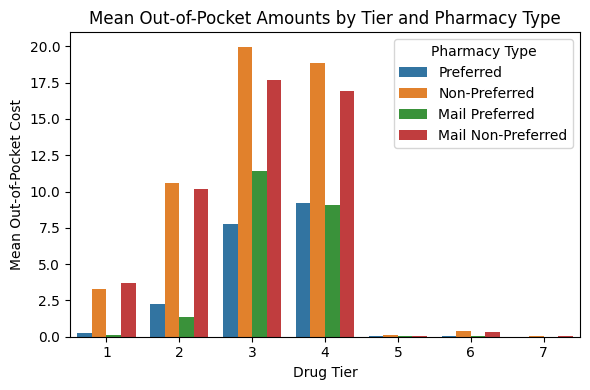

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape DataFrame for easier plotting
melted = agg_df.melt(id_vars='tier', 
    value_vars=[
        'cost_amt_pref_mean', 'cost_amt_pref_median',
        'cost_amt_nonpref_mean', 'cost_amt_nonpref_median',
        'cost_amt_mail_pref_mean', 'cost_amt_mail_pref_median',
        'cost_amt_mail_nonpref_mean', 'cost_amt_mail_nonpref_median'
    ],
    var_name='cost_type_stat',
    value_name='cost'
)

# Split 'cost_type_stat' into 'cost_type' and 'stat'
melted[['cost_type', 'stat']] = melted['cost_type_stat'].str.rsplit('_', n=1, expand=True)
cost_type_labels = {
    'cost_amt_pref': 'Preferred',
    'cost_amt_nonpref': 'Non-Preferred',
    'cost_amt_mail_pref': 'Mail Preferred',
    'cost_amt_mail_nonpref': 'Mail Non-Preferred'
}
melted['cost_type'] = melted['cost_type'].map(cost_type_labels)

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(
    data=melted[melted['stat'] == 'mean'],
    x='tier',
    y='cost',
    hue='cost_type'
)
plt.title('Mean Out-of-Pocket Amounts by Tier and Pharmacy Type')
plt.xlabel('Drug Tier')
plt.ylabel('Mean Out-of-Pocket Cost')
plt.legend(title='Pharmacy Type')
plt.tight_layout()
plt.show()


In [ ]:
# Export the aggregated DataFrame to a JSON file
agg_df.to_json('analyzing_patient_pocket.json', orient='records', indent=4)

How does average out-of-pocket cost change across drug tiers?
The mean out-of-pocket cost increases substantially as drug tier level rises from 1 to 4 across all pharmacy types. The lowest tiers (1 and 2) have low average costs, indicating greater affordability. Tiers 3 and 4 see a large jump in patient costs, confirming that higher tiers are less affordable and lower tiers consistently favor patient savings.

Are certain pharmacy types systematically less expensive?
Yes, preferred pharmacy options (both retail and mail) show lower mean out-of-pocket costs than their non-preferred counterparts in all drug tiers. This pattern is consistent: for each tier, preferred options are always the most affordable channel for patients, while non-preferred pharmacy types are systematically more expensive at every step.

Do higher tiers show disproportionate increases in cost?
There is a sharp and disproportionate increase in mean out-of-pocket costs between tier 2 and tiers 3–4. Tiers 3 and 4 especially have mean costs that are several times higher than earlier tiers, indicating a significant barrier for patients requiring higher-tier (often branded or specialty) drugs.

Does the difference in cost between preferred and non-preferred pharmacies change by tier?
The cost gap between preferred and non-preferred pharmacy types widens notably as the tier increases. At lower tiers, the difference is minor, but in higher tiers, especially 3 and 4, non-preferred pharmacies are much more expensive than preferred options. This shows that plan design (pharmacy preference and tier) has its strongest financial impact at higher tiers, further penalizing patients who do not use preferred pharmacies for more expensive medicines.